#1. Clases Principales
Cellpose (Línea 86)
Clase principal que combina SizeModel y CellposeModel.
Método clave de segmentación:

- eval() (Línea 119): Función principal para segmentar imágenes

  - Entrada: Imágenes (lista o array)
  - Salida: máscaras, flows, styles, diámetros
  - Parámetros importantes:

    - diameter: Diámetro de las células (default 30)
    - flow_threshold: Umbral de error de flujo (default 0.4)
    - cellprob_threshold: Umbral de probabilidad celular (default 0.0)
    - min_size: Tamaño mínimo de máscara en píxeles (default 15)
    - channels: Canales a usar [canal_segmentar, canal_nuclear]
    - do_3D: Para segmentación 3D

- CellposeModel (Línea 194)

Modelo de red neuronal para segmentación.

Métodos de segmentación:


- eval() (Línea 248)

Segmenta imágenes usando la red neuronal.

Procesa imágenes individuales o lotes.

Normaliza y redimensiona según parámetros

Retorna: masks, flows, styles


- _run_cp() (Línea 364)

Función interna principal que ejecuta el pipeline completo:

Normaliza las imágenes

Ejecuta la red neuronal (_run_nets())

Genera los flujos (dP) y probabilidades (cellprob)

Calcula las máscaras con _compute_masks()

In [ ]:
rescale=1.0          # Factor de redimensionamiento
net_avg=True         # Promediar 4 redes
augment=False        # Aumentación de datos
tile=True            # División en tiles para GPU
cellprob_threshold   # Umbral probabilidad
flow_threshold       # Umbral de flujo
min_size            # Tamaño mínimo máscara

- _compute_masks() (Línea 427)

Genera las máscaras finales a partir de flujos y probabilidades.

Proceso:

1 - dynamics.follow_flows(): Sigue los flujos de gradiente
- Usa flujos direccionales (dP) multiplicados por la probabilidad celular
- Itera niter veces (200 para 2D, ajustado para 3D)

2 - dynamics.get_masks(): Convierte flujos en máscaras discretas
- Aplica flow_threshold para filtrar células
- Usa cellprob_threshold para determinar qué píxeles son células

3 - utils.fill_holes_and_remove_small_masks(): Limpieza
- Rellena huecos en las máscaras
- Elimina objetos más pequeños que min_size

4 - Redimensiona a tamaño original si es necesario

# 2. Funciones Auxiliares Importantes
dx_to_circ() (Línea 64)

Convierte flujos de gradiente a representación visual HSV (colores).

- Transforma flujos direccionales en imagen RGB
- Útil para visualización

# 3. Pipeline de Segmentación Completo

In [ ]:
IMAGEN DE ENTRADA
    ↓
[Normalización] transforms.normalize_img()
    ↓
[Redimensionamiento] transforms.resize_image()
    ↓
[Red Neuronal] _run_nets()
    ↓
PREDICCIONES: dP (flujos) + cellprob (probabilidades)
    ↓
[Seguimiento de Flujos] dynamics.follow_flows()
    ↓
[Generación de Máscaras] dynamics.get_masks()
    ↓
[Limpieza] fill_holes_and_remove_small_masks()
    ↓
MÁSCARAS FINALES

# 4. Parámetros Críticos para Segmentación
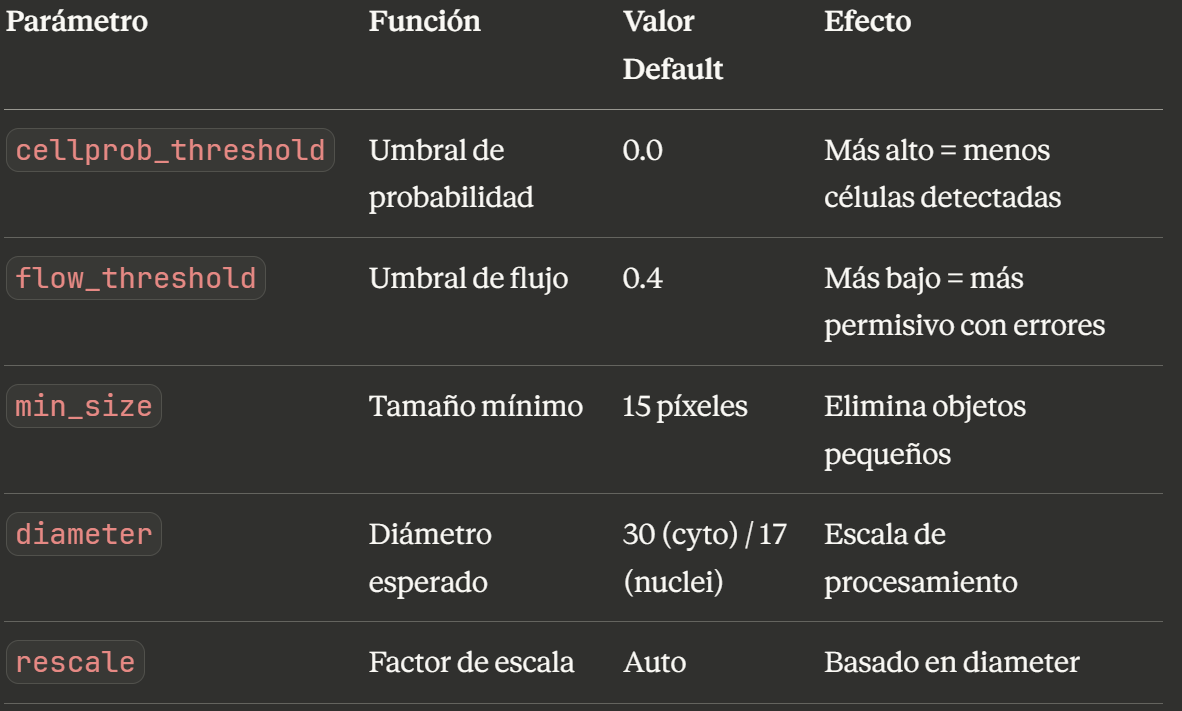

#5. Módulos Externos Utilizados
El archivo importa funciones de segmentación de otros módulos:
- dynamics: Seguimiento de flujos y generación de máscaras
- transforms: Normalización y transformaciones de imagen
- utils: Funciones auxiliares (rellenar huecos, calcular diámetros)

#6. Ejemplo de Uso Básico


In [ ]:
# Crear modelo
model = Cellpose(gpu=True, model_type='cyto')

# Segmentar imagen
masks, flows, styles, diams = model.eval(
    imagen,
    diameter=30,
    channels=[0,0],  # [canal_células, canal_núcleos]
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    min_size=15
)

#7. Para Núcleos, Micronúcleos, etc.
Para tu aplicación específica de conteo de núcleos y micronúcleos:

**1 - Núcleos**: Usa model_type='nuclei' (diameter≈17)
**2 - Ajusta min_size**: Para micronúcleos usa valores más pequeños (ej: 5-10)
**3 - Ajusta cellprob_threshold**: Para detectar objetos más tenues
**4 - Post-procesamiento**: Las máscaras resultantes pueden analizarse para:
- Contar objetos: np.unique(masks)
- Clasificar por tamaño: diferenciar núcleos vs micronúcleos
- Detectar binucleadas/trinucleadas: analizar proximidad/agrupación